# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import os
import time
import json
import numpy as np
from shutil import copyfile
import tensorflow as tf
from PIL import Image
import pandas as pd
import glob
from keras.preprocessing.text import Tokenizer
import itertools
from nltk.tokenize import word_tokenize
import collections
from collections import Counter
from nltk import FreqDist
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize.util import xml_unescape
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

C:\Users\e0368301\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Understanding the images, extracting the path where the images are stored

images='./data/Images/'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

path=[line.split('\\')[0] for line in all_imgs]
print(len(path))
path=list(itertools.chain.from_iterable(itertools.repeat(x, 5) for x in path))
print(len(path))

The total images present in the dataset: 8091
8091
40455


In [3]:
#Understand the caption, the way it is stored
# Reading the captions into a list, extracting only the captions, dropping the image names

captions = [line.strip() for line in open("./data/captions.txt", 'r')]
captions.pop(0)

image_name = [line.split(',')[0] for line in captions]

captions = [elem.split('.jpg,')[-1] for elem in captions]

print("Length of Captions:",len(captions))

Length of Captions: 40455


In [4]:
# Viewing the captions of the images
captions

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .',
 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails pain

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
all_img_id= image_name #store all the image id here
all_img_vector= path #store all the image path here
annotations= captions #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
# Visualizing the DataFrame containing Image names, the image path and its corresponding captions
df.head(20)

ID           Path  \
0   1000268201_693b08cb0e.jpg  ./data/Images   
1   1000268201_693b08cb0e.jpg  ./data/Images   
2   1000268201_693b08cb0e.jpg  ./data/Images   
3   1000268201_693b08cb0e.jpg  ./data/Images   
4   1000268201_693b08cb0e.jpg  ./data/Images   
5   1001773457_577c3a7d70.jpg  ./data/Images   
6   1001773457_577c3a7d70.jpg  ./data/Images   
7   1001773457_577c3a7d70.jpg  ./data/Images   
8   1001773457_577c3a7d70.jpg  ./data/Images   
9   1001773457_577c3a7d70.jpg  ./data/Images   
10  1002674143_1b742ab4b8.jpg  ./data/Images   
11  1002674143_1b742ab4b8.jpg  ./data/Images   
12  1002674143_1b742ab4b8.jpg  ./data/Images   
13  1002674143_1b742ab4b8.jpg  ./data/Images   
14  1002674143_1b742ab4b8.jpg  ./data/Images   
15  1003163366_44323f5815.jpg  ./data/Images   
16  1003163366_44323f5815.jpg  ./data/Images   
17  1003163366_44323f5815.jpg  ./data/Images   
18  1003163366_44323f5815.jpg  ./data/Images   
19  1003163366_44323f5815.jpg  ./data/Images   

                                             Captions  
0   A child in a pink dress is climbing up a set o...  
1               A girl going into a wooden building .  
2    A little girl climbing into a wooden playhouse .  
3   A little girl climbing the stairs to her playh...  
4   A little girl in a pink dress going into a woo...  
5          A black dog and a spotted dog are fighting  
6   A black dog and a tri-colored dog playing with...  
7   A black dog and a white dog with brown spots a...  
8   Two dogs of different breeds looking at each o...  
9     Two dogs on pavement moving toward each other .  
10  A little girl covered in paint sits in front o...  
11  A little girl is sitting in front of a large p...  
12  A small girl in the grass plays with fingerpai...  
13  There is a girl with pigtails sitting in front...  
14  Young girl with pigtails painting outside in t...  
15  A man lays on a bench while his dog sits by him .  
16  A man lays on the bench to which a white dog i...  
17  a man sleeping on a bench outside with a white...  
18  A shirtless man lies on a park bench with his ...  
19  man laying on bench holding leash of dog sitti...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


### Visualizing few images using the information stored in the dataframe

A child in a pink dress is climbing up a set of stairs in an entry way .
A girl going into a wooden building .
A little girl climbing into a wooden playhouse .
A little girl climbing the stairs to her playhouse .
A little girl in a pink dress going into a wooden cabin .


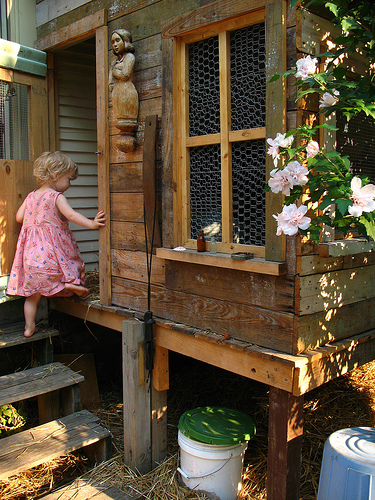

In [7]:
print(df.Captions[0])
print(df.Captions[1])
print(df.Captions[2])
print(df.Captions[3])
print(df.Captions[4])
Image.open(df.Path[0]+'/'+df.ID[0])

A child swinging a multi-colored banner .
A young boy is playing with a colorful streamer .
a young boy waving a streaming kite
A young child plays with a colorful toy outside .
The boy is playing with a colorful ribbon .


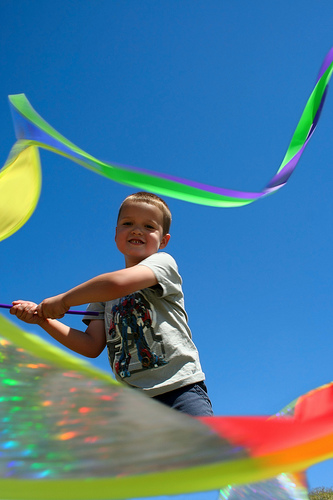

In [8]:
print(df.Captions[10000])
print(df.Captions[10001])
print(df.Captions[10002])
print(df.Captions[10003])
print(df.Captions[10004])
Image.open(df.Path[0]+'/'+df.ID[10002])

Dog leaps high for yellow ball as another dog waits below on grass .
"These two dogs are outside , with one on the ground and one jumping in the air to get a ball ."
Two dog play with ball while one makes a big jump
Two dogs play with a ball in a field .
Two dogs play with tennis ball in field .


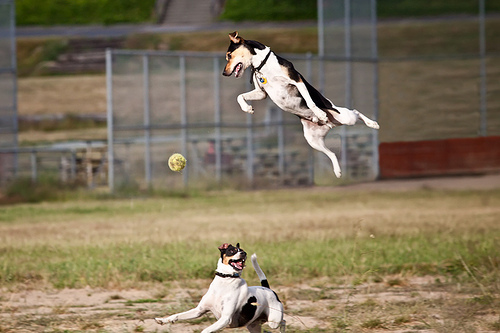

In [9]:
print(df.Captions[34565])
print(df.Captions[34566])
print(df.Captions[34567])
print(df.Captions[34568])
print(df.Captions[34569])
Image.open(df.Path[0]+'/'+df.ID[34568])

In [10]:
#Create the vocabulary & the counter for the captions
corpus=[word_tokenize(line) for line in captions]
print(len(corpus))
corpus=[word for sent in corpus for word in sent]
print(len(corpus))
corpus = [word.lower() for word in corpus]
corpus

40455
482003


['a',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.',
 'a',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 '.',
 'a',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 '.',
 'a',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 '.',
 'a',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 '.',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 '.',
 'two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 '.',
 'two'

In [11]:
val_count=Counter(corpus)
val_count

Counter({'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6713,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         '.': 36583,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18418,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'at': 

In [12]:
# Function to plot the word frequency for the number of words passed to this function
def plot_word_frequency(words, top_n=10):
    word_freq = FreqDist(words)
    print(word_freq.most_common(1)[0][1])
    labels = [element[0] for element in word_freq.most_common(top_n)]
    print(labels)
    counts = [element[1] for element in word_freq.most_common(top_n)]
    print(counts)
    plt.figure(figsize=(18,8))
    plot = sns.barplot(labels, counts)
    return plot

62986
['a', '.', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', ',', 'to', 'wearing', 'at', 'people', 'water', '``', "''", 'red', 'young', 'brown', 'an']
[62986, 36583, 18974, 18418, 10743, 9345, 8851, 8136, 7765, 7265, 6713, 5638, 3940, 3832, 3581, 3504, 3402, 3328, 3232, 3173, 3062, 2915, 2883, 2783, 2782, 2782, 2672, 2630, 2563, 2432]


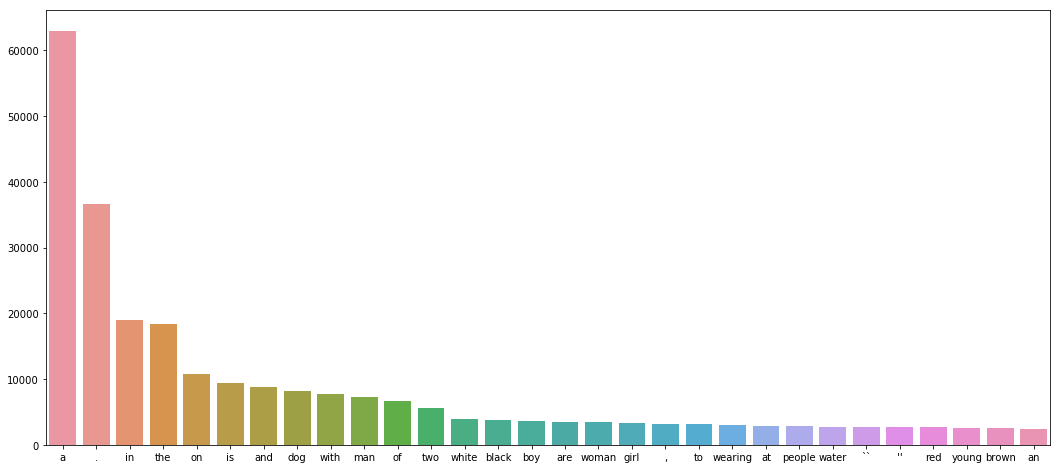

In [13]:
#Visualise the top 30 occuring words in the captions
plot_word_frequency(corpus, 30)


In [14]:
#Create a list which contains all the captions
annotations=[]

#Adding the <start> & <end> token to all those captions as well
for sent in captions:
    new_sent = " ".join(['<start>',sent,'<end>'])
    annotations.append(new_sent)

print("Total captions present in the dataset: "+ str(len(annotations)))

Total captions present in the dataset: 40455


In [15]:
#Visualising the Caption after adding the start and end token
annotations[7]

'<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>'

In [16]:
#Create a list which contains all the path to the images
all_img_path=["".join([item[1],item[0]]) for item in list(zip(all_img_id, all_img_vector))]

print("Total images present in the dataset: " + str(len(all_img_path)))

Total images present in the dataset: 40455


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [17]:
# create the tokenizer using KERAS TOKENIZER
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
# Adding the index 0 for PAD
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
seq=tokenizer.texts_to_sequences(annotations)

### Visualising the Sequence and the word index generated

In [18]:
print(seq)

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4], [3, 2, 20, 317, 65, 2, 197, 118, 4], [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4], [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4], [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4], [3, 2, 16, 10, 9, 2, 844, 10, 18, 344, 4], [3, 2, 16, 10, 9, 2, 1576, 236, 10, 35, 11, 138, 83, 7, 6, 152, 4], [3, 2, 16, 10, 9, 2, 15, 10, 11, 28, 1002, 18, 641, 23, 138, 83, 5, 6, 73, 4], [3, 14, 32, 13, 742, 2654, 90, 23, 138, 83, 7, 6, 152, 4], [3, 14, 32, 7, 728, 806, 322, 138, 83, 4], [3, 2, 41, 20, 165, 5, 607, 107, 5, 49, 13, 2, 595, 1194, 11, 61, 221, 5, 2, 977, 4], [3, 2, 41, 20, 8, 50, 5, 49, 13, 2, 56, 595, 1194, 4], [3, 2, 54, 20, 5, 6, 42, 115, 11, 3422, 5, 49, 13, 2, 15, 2439, 11, 2, 1194, 7, 150, 4], [3, 190, 8, 2, 20, 11, 1577, 50, 5, 49, 13, 2, 1194, 773, 4], [3, 27, 20, 11, 1577, 773, 82, 5, 6, 42, 4], [3, 2, 12, 647, 7, 2, 163, 36, 30, 10, 107, 55, 149, 4], [3, 2, 12, 647, 7, 6, 163, 21, 694, 2, 15, 10, 8, 1270, 1

In [19]:
print(tokenizer.word_index)

{'<unk>': 1, 'a': 2, '<start>': 3, '<end>': 4, 'in': 5, 'the': 6, 'on': 7, 'is': 8, 'and': 9, 'dog': 10, 'with': 11, 'man': 12, 'of': 13, 'two': 14, 'white': 15, 'black': 16, 'boy': 17, 'are': 18, 'woman': 19, 'girl': 20, 'to': 21, 'wearing': 22, 'at': 23, 'people': 24, 'water': 25, 'red': 26, 'young': 27, 'brown': 28, 'an': 29, 'his': 30, 'blue': 31, 'dogs': 32, 'running': 33, 'through': 34, 'playing': 35, 'while': 36, 'shirt': 37, 'down': 38, 'standing': 39, 'ball': 40, 'little': 41, 'grass': 42, 'snow': 43, 'child': 44, 'person': 45, 'jumping': 46, 'over': 47, 'three': 48, 'front': 49, 'sitting': 50, 'holding': 51, 'up': 52, 'field': 53, 'small': 54, 'by': 55, 'large': 56, 'green': 57, 'one': 58, 'group': 59, 'yellow': 60, 'her': 61, 'walking': 62, 'children': 63, 'men': 64, 'into': 65, 'air': 66, 'beach': 67, 'near': 68, 'mouth': 69, 'jumps': 70, 'another': 71, 'for': 72, 'street': 73, 'runs': 74, 'its': 75, 'from': 76, 'riding': 77, 'stands': 78, 'as': 79, 'bike': 80, 'girls': 81,

In [20]:
# Create word-to-index and index-to-word mappings.
word_to_index = tokenizer.word_index
index_to_word = {v: k for k, v in tokenizer.word_index.items()}

In [21]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
text_from_sequence = list(tokenizer.sequences_to_texts_generator(seq))

In [22]:
result=[]
for elem in text_from_sequence:
    result.extend(elem.split())
result

['<start>',
 'a',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 '<unk>',
 'way',
 '<end>',
 '<start>',
 'a',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 '<end>',
 '<start>',
 'a',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'tri',
 'colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 '<end>',
 '<start>',
 'a',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'stre

### Plotting the word frequency post capping the vocab and adding the `<start>` and `<end>` tags

62992
['a', '<start>', '<end>', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', '<unk>', 'boy', 'are', 'woman', 'girl', 'to', 'wearing', 'at', 'people', 'water', 'red', 'young', 'brown', 'an', 'his']
[62992, 40455, 40455, 18986, 18419, 10745, 9345, 8862, 8138, 7765, 7274, 6723, 5642, 3959, 3848, 3657, 3581, 3504, 3402, 3328, 3176, 3062, 2915, 2883, 2790, 2691, 2630, 2578, 2432, 2357]


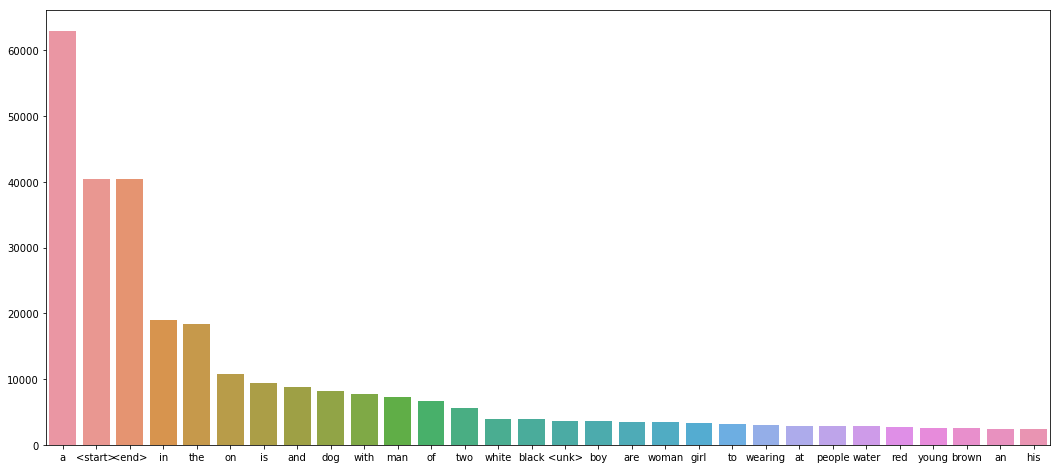

In [23]:
plot_word_frequency(result, 30)

In [24]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
max_length = max([len(sent.split()) for sent in text_from_sequence])
print("Max Length: ", max_length)
cap_vector=pad_sequences(seq,padding="post",truncating='post',maxlen=max_length)
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max Length:  39
The shape of Caption vector is :(40455, 39)


In [25]:
cap_vector.shape

(40455, 39)

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [26]:
images='/data/Images'
im_path = os.getcwd() + images
im_path

'C:\\Users\\e0368301\\PGD\\C8_Deployment\\Project/data/Images'

In [27]:
#write your code here
image_path = os.path.join(im_path, '*')
print(image_path)

# glob through the directory (returns a list of all file paths)
image_path = glob.glob(image_path)
print(image_path[1]) # access an individual file
#print(image_path)

C:\Users\e0368301\PGD\C8_Deployment\Project/data/Images\*
C:\Users\e0368301\PGD\C8_Deployment\Project/data/Images\1001773457_577c3a7d70.jpg


In [28]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for count, val in enumerate(annotations):
    image_path_to_caption[image_path[count//5]].append(val)

In [29]:
image_path_to_caption

defaultdict(list,
            {'C:\\Users\\e0368301\\PGD\\C8_Deployment\\Project/data/Images\\1000268201_693b08cb0e.jpg': ['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
              '<start> A girl going into a wooden building . <end>',
              '<start> A little girl climbing into a wooden playhouse . <end>',
              '<start> A little girl climbing the stairs to her playhouse . <end>',
              '<start> A little girl in a pink dress going into a wooden cabin . <end>'],
             'C:\\Users\\e0368301\\PGD\\C8_Deployment\\Project/data/Images\\1001773457_577c3a7d70.jpg': ['<start> A black dog and a spotted dog are fighting <end>',
              '<start> A black dog and a tri-colored dog playing with each other on the road . <end>',
              '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>',
              '<start> Two dogs of different breeds looking at each other on t

In [30]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

#### Visualising few images

['<start> A black dog and a spotted dog are fighting <end>', '<start> A black dog and a tri-colored dog playing with each other on the road . <end>', '<start> A black dog and a white dog with brown spots are staring at each other in the street . <end>', '<start> Two dogs of different breeds looking at each other on the road . <end>', '<start> Two dogs on pavement moving toward each other . <end>']


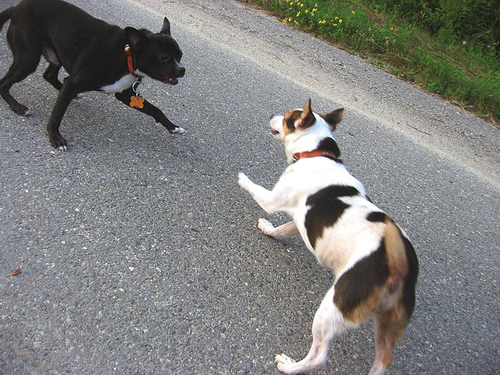

In [31]:
print(image_path_to_caption[image_path[1]])
Image.open(image_path[1])

['<start> A girl spins a merry-go-round at a playground . <end>', '<start> A little girl pushes a merry go round in a park while two other kids hold on . ee <end>', '<start> Children playing on a playground . <end>', '<start> Children playing on a roundabout . <end>', '<start> Little girl spinning playground merry-go-round as other kids ride . <end>']


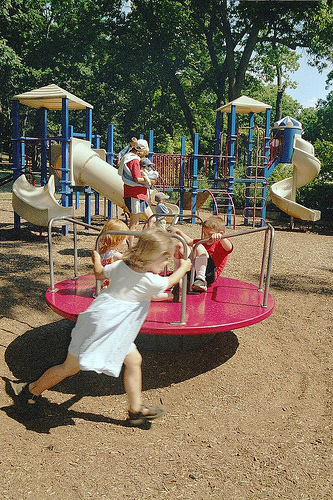

In [32]:
im_id=np.random.randint(0, len(image_path_to_caption))
print(image_path_to_caption[image_path[im_id]])
Image.open(image_path[im_id])

['<start> A black dog and small white and black dog look up at a kitchen countertop . <end>', '<start> A large dog and a small dog stand next to the kitchen counter to investigate . <end>', '<start> a small black and white dog standing next to a large black dog both looking up onto a counter . <end>', '<start> "Dogs ignore plate of food on floor , look up at kitchen counter ." <end>', '<start> The dogs are begging at the kitchen counter . <end>']


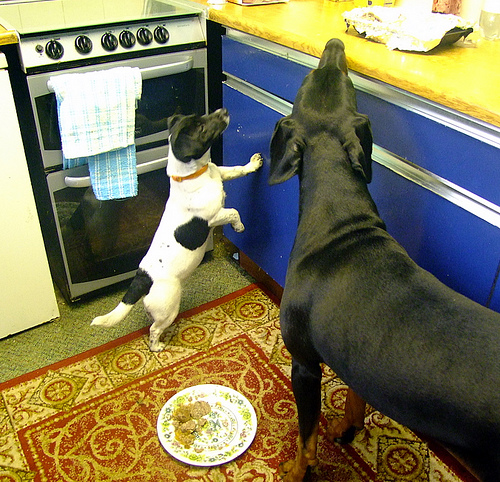

In [33]:
im_id=np.random.randint(0, len(image_path_to_caption))
print(image_path_to_caption[image_path[im_id]])
Image.open(image_path[im_id])

In [34]:
image_path_to_caption['C:\\Users\\e0368301\\PGD\\C8_Deployment\\Project/data/Images\\1363924449_487f0733df.jpg']

['<start> A boy holds his hands on his head . <end>',
 '<start> A child with his hands on his head . <end>',
 '<start> A little boy in a striped shirt has his hands on his head . <end>',
 '<start> A little boy stands with his hands on top of his head <end>',
 '<start> The blond boy wearing a striped shirt is walking through the grass . <end>']

In [35]:
train_captions = []
img_name_vector = []

for im_path in image_paths:
    caption_list = image_path_to_caption[im_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([im_path] * len(caption_list))

In [36]:
train_captions

['<start> "A man poses for a little girl , his arms outstretched , with a large church in the background ." <end>',
 '<start> A man standing on one foot with a little girl in front of a cathedral . <end>',
 '<start> A man stands on one leg in a playful pose near a lamppost as a young girl looks on . <end>',
 "<start> The back of a little girl with braids and a man in a ' plane ' pose before her . <end>",
 '<start> The man is posing in front of a small child near a light post . <end>',
 '<start> A bike sits atop a rise with mountains in the background . <end>',
 '<start> A man wearing a red uniform and helmet stands on his motorbike . <end>',
 '<start> A motocross bike is being ridden over rocks . <end>',
 '<start> A motocross biker about to descend <end>',
 '<start> The motorcyclist has reached the summit . <end>',
 '<start> a boy with a fishing pole looking down on a lake <end>',
 '<start> A little boy looks over the railing on the dock into the blue water . <end>',
 '<start> A young 

In [37]:
# create the tokenizer
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
seq=tokenizer.texts_to_sequences(train_captions)

# Create word-to-index and index-to-word mappings.
word_to_index = tokenizer.word_index
index_to_word = {v: k for k, v in tokenizer.word_index.items()}

# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
text_from_sequence = list(tokenizer.sequences_to_texts_generator(seq))

# Pad each vector to the max_length of the captions ^ store it to a vairable
max_length = max([len(sent.split()) for sent in text_from_sequence])
print("Max Length: ", max_length)
cap_vector=pad_sequences(seq,padding="post",truncating='post',maxlen=max_length)
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max Length:  39
The shape of Caption vector is :(40455, 39)


#### Preprocess the image to resize to the required size and normalize

In [38]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

#### Imagenet model created

In [39]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

#### batch size and shape configured

In [40]:
BATCH_SIZE = 64
shape = (299, 299)

In [41]:
processed='/data/processed'
OUTPUT_IMAGE_PATH = os.getcwd() + processed
OUTPUT_IMAGE_PATH

'C:\\Users\\e0368301\\PGD\\C8_Deployment\\Project/data/processed'

In [42]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)


##### Storing the features of the images in the npy files

In [43]:
if not os.path.exists(OUTPUT_IMAGE_PATH):
    os.mkdir(OUTPUT_IMAGE_PATH)
images_npy = []
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        file_name = p.numpy().decode("utf-8").split('\\')[-1]
        images_npy.append(file_name)
        np.save( OUTPUT_IMAGE_PATH +"/"+file_name, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [30:19<00:00, 14.33s/it]


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [44]:
len(img_name_vector)

40455

In [45]:
len(cap_vector)

40455

In [46]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)


In [47]:
len(img_to_cap_vector)

8091

In [48]:
img_to_cap_vector

defaultdict(list,
            {'C:\\Users\\e0368301\\PGD\\C8_Deployment\\Project/data/Images\\3495453699_1c9faedf3c.jpg': [array([   3,    2,   12,  330,   72,    2,   41,   20,   30,  218,  844,
                       11,    2,   56, 1270,    5,    6,  103,    4,    0,    0,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0,    0,    0]),
              array([  3,   2,  12,  39,   7,  58, 763,  11,   2,  41,  20,   5,  49,
                      13,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,
                       0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
              array([   3,    2,   12,   78,    7,   58,  631,    5,    2, 2263,  239,
                       68,    2,    1,   79,    2,   27,   20,  117,    7,    4,    0,
                        0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0,    0,    0,

### Create training and validation sets using an 80-20 split randomly.


In [49]:
cap_vector.shape

(40455, 39)

In [50]:
len(img_name_vector)

40455

In [51]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=42)

In [52]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32364, 32364, 8091, 8091)

##### Required Hyperparameters are set

In [53]:

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = 5000 + 1
num_steps = len(img_name_train) // BATCH_SIZE
num_steps_test = len(img_name_val) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


#### Features are being read for both train and test images

In [54]:
img_train_numpy=[]
for item in img_name_train:
    img_train_numpy.append(OUTPUT_IMAGE_PATH +"/"+item.split('\\')[-1]+'.npy')


In [55]:
img_test_numpy=[]
for item in img_name_val:
    img_test_numpy.append(OUTPUT_IMAGE_PATH +"/"+item.split('\\')[-1]+'.npy')


In [56]:
len(img_test_numpy)

8091

In [57]:
OUTPUT_IMAGE_PATH

'C:\\Users\\e0368301\\PGD\\C8_Deployment\\Project/data/processed'

In [58]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name)
    return img_tensor, cap

#### Creating Train Dataset using Dataset API

In [59]:
dataset = tf.data.Dataset.from_tensor_slices((img_train_numpy, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [60]:
sample_img_batch, sample_cap_batch = next(iter(dataset))

print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [61]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_name_train) // BATCH_SIZE
test_num_steps = len(img_name_val) // BATCH_SIZE

### Encoder

In [62]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embedding_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        
        return features

In [63]:
encoder=Encoder(embedding_dim)

### Attention model

In [64]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [65]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed =  self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [66]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [67]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [68]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') #define your loss object

In [69]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [70]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [71]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)    

In [72]:
loss_plot=[]

In [73]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    #print("Before for loop, dec_input shape:", dec_input.shape)
    
    with tf.GradientTape() as tape:
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            #print("Predictions shape:",predictions.shape)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            #print("Updated dec input shape:",dec_input.shape)

    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
          
    return loss, avg_loss

### Creating test dataset using Dataset API

In [74]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_test_numpy, cap_val))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##### Test Step functions calculating the loss on the test dataset

In [75]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    print("Inside Test_step")
    #write your code here to do the testing steps
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        new_pred = tf.argmax(predictions, axis=1)
        new_pred = tf.expand_dims(new_pred, 1)
        loss += loss_function(target[:, i], predictions)
        #Assigning the predicted value in the current step as decoder input in the next step
        dec_input = new_pred    

    avg_loss = (loss / int(target.shape[1]))
    return avg_loss, loss

In [76]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += batch_loss
        if batch % 25 == 0:
            print ('Batch {} Batch Loss {:.4f} Total Loss {:.4f}'.format(
              batch, batch_loss, total_loss))

    avg_test_loss = total_loss / test_num_steps
    return avg_test_loss

In [77]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
            
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    avg_train_loss=total_loss / train_num_steps
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 1.2222
Epoch 1 Batch 100 Loss 1.0809
Epoch 1 Batch 200 Loss 1.1893
Epoch 1 Batch 300 Loss 1.0572
Epoch 1 Batch 400 Loss 1.0764
Epoch 1 Batch 500 Loss 1.1206
Inside Test_step
Batch 0 Batch Loss 2.1065 Total Loss 2.1065
Batch 25 Batch Loss 2.1689 Total Loss 58.4194
Batch 50 Batch Loss 2.1329 Total Loss 115.2050
Batch 75 Batch Loss 2.3477 Total Loss 171.0612
Batch 100 Batch Loss 2.3974 Total Loss 227.1298
Batch 125 Batch Loss 2.1733 Total Loss 283.8740
For epoch: 1, the train loss is 1.108, & test loss is 2.253
Time taken for 1 epoch 2791.869047641754 sec

Test loss has been reduced from 100.000 to 2.253


  7%|█████▏                                                                        | 1/15 [46:32<10:51:32, 2792.35s/it]

Epoch 2 Batch 0 Loss 1.1254
Epoch 2 Batch 100 Loss 0.9914
Epoch 2 Batch 200 Loss 1.0790
Epoch 2 Batch 300 Loss 0.9713
Epoch 2 Batch 400 Loss 0.8756
Epoch 2 Batch 500 Loss 1.0208
Batch 0 Batch Loss 2.4660 Total Loss 2.4660
Batch 25 Batch Loss 2.2743 Total Loss 60.5094
Batch 50 Batch Loss 2.4023 Total Loss 118.8503
Batch 75 Batch Loss 2.3007 Total Loss 176.1679
Batch 100 Batch Loss 2.3106 Total Loss 234.9343


 13%|██████████▎                                                                  | 2/15 [1:26:15<9:38:26, 2669.73s/it]

Batch 125 Batch Loss 2.3934 Total Loss 293.7933
For epoch: 2, the train loss is 1.014, & test loss is 2.332
Time taken for 1 epoch 2383.61909198761 sec

Epoch 3 Batch 0 Loss 1.0413
Epoch 3 Batch 100 Loss 0.8983
Epoch 3 Batch 200 Loss 0.8600
Epoch 3 Batch 300 Loss 0.9509
Epoch 3 Batch 400 Loss 0.9772
Epoch 3 Batch 500 Loss 1.0388
Batch 0 Batch Loss 2.4401 Total Loss 2.4401
Batch 25 Batch Loss 2.1175 Total Loss 60.5405
Batch 50 Batch Loss 2.2101 Total Loss 118.9574
Batch 75 Batch Loss 2.5076 Total Loss 177.5017
Batch 100 Batch Loss 2.3873 Total Loss 235.6722


 20%|███████████████▍                                                             | 3/15 [2:03:17<8:27:01, 2535.15s/it]

Batch 125 Batch Loss 2.3261 Total Loss 294.3957
For epoch: 3, the train loss is 0.976, & test loss is 2.336
Time taken for 1 epoch 2221.1027131080627 sec

Epoch 4 Batch 0 Loss 0.9916
Epoch 4 Batch 100 Loss 0.9547
Epoch 4 Batch 200 Loss 1.0264
Epoch 4 Batch 300 Loss 0.9301
Epoch 4 Batch 400 Loss 0.9317
Epoch 4 Batch 500 Loss 0.9589
Batch 0 Batch Loss 2.3129 Total Loss 2.3129
Batch 25 Batch Loss 2.1885 Total Loss 58.9813
Batch 50 Batch Loss 2.2526 Total Loss 115.6656
Batch 75 Batch Loss 2.3319 Total Loss 172.1963
Batch 100 Batch Loss 2.4085 Total Loss 229.2873


 27%|████████████████████▌                                                        | 4/15 [2:39:55<7:26:14, 2434.03s/it]

Batch 125 Batch Loss 2.3755 Total Loss 286.5175
For epoch: 4, the train loss is 0.952, & test loss is 2.274
Time taken for 1 epoch 2198.09645485878 sec

Epoch 5 Batch 0 Loss 0.8182
Epoch 5 Batch 100 Loss 0.9004
Epoch 5 Batch 200 Loss 0.8694
Epoch 5 Batch 300 Loss 0.9086
Epoch 5 Batch 400 Loss 0.8763
Epoch 5 Batch 500 Loss 0.9208
Batch 0 Batch Loss 2.2359 Total Loss 2.2359
Batch 25 Batch Loss 2.1561 Total Loss 57.7924
Batch 50 Batch Loss 2.3775 Total Loss 112.9394
Batch 75 Batch Loss 2.1730 Total Loss 167.4032
Batch 100 Batch Loss 2.3136 Total Loss 222.1062
Batch 125 Batch Loss 2.2124 Total Loss 277.6232
For epoch: 5, the train loss is 0.935, & test loss is 2.203
Time taken for 1 epoch 2173.5294137001038 sec

Test loss has been reduced from 2.253 to 2.203


 33%|█████████████████████████▋                                                   | 5/15 [3:16:09<6:32:40, 2356.02s/it]

Epoch 6 Batch 0 Loss 0.8836
Epoch 6 Batch 100 Loss 0.9168
Epoch 6 Batch 200 Loss 0.8773
Epoch 6 Batch 300 Loss 0.8711
Epoch 6 Batch 400 Loss 0.8802
Epoch 6 Batch 500 Loss 0.9910
Batch 0 Batch Loss 2.4098 Total Loss 2.4098
Batch 25 Batch Loss 2.3542 Total Loss 62.7514
Batch 50 Batch Loss 2.4033 Total Loss 122.7157
Batch 75 Batch Loss 2.4625 Total Loss 181.7281
Batch 100 Batch Loss 2.5696 Total Loss 241.7194


 40%|██████████████████████████████▊                                              | 6/15 [3:52:55<5:46:39, 2311.06s/it]

Batch 125 Batch Loss 2.4701 Total Loss 302.5206
For epoch: 6, the train loss is 0.923, & test loss is 2.401
Time taken for 1 epoch 2206.1577484607697 sec

Epoch 7 Batch 0 Loss 0.9251
Epoch 7 Batch 100 Loss 0.9303
Epoch 7 Batch 200 Loss 0.9549
Epoch 7 Batch 300 Loss 0.9405
Epoch 7 Batch 400 Loss 0.9405
Epoch 7 Batch 500 Loss 0.8691
Batch 0 Batch Loss 2.4130 Total Loss 2.4130
Batch 25 Batch Loss 2.3435 Total Loss 62.5771
Batch 50 Batch Loss 2.5609 Total Loss 123.0145
Batch 75 Batch Loss 2.3041 Total Loss 181.9948
Batch 100 Batch Loss 2.3016 Total Loss 242.2486


 47%|███████████████████████████████████▉                                         | 7/15 [4:29:31<5:03:31, 2276.47s/it]

Batch 125 Batch Loss 2.3927 Total Loss 302.6759
For epoch: 7, the train loss is 0.912, & test loss is 2.402
Time taken for 1 epoch 2195.7430391311646 sec

Epoch 8 Batch 0 Loss 0.9928
Epoch 8 Batch 100 Loss 0.8969
Epoch 8 Batch 200 Loss 0.9015
Epoch 8 Batch 300 Loss 0.9083
Epoch 8 Batch 400 Loss 0.9339
Epoch 8 Batch 500 Loss 0.8972
Batch 0 Batch Loss 2.3489 Total Loss 2.3489
Batch 25 Batch Loss 2.2733 Total Loss 62.6144
Batch 50 Batch Loss 2.2475 Total Loss 122.1190
Batch 75 Batch Loss 2.2910 Total Loss 181.1442
Batch 100 Batch Loss 2.4285 Total Loss 241.3100


 53%|█████████████████████████████████████████                                    | 8/15 [5:06:10<4:22:54, 2253.47s/it]

Batch 125 Batch Loss 2.5282 Total Loss 301.7108
For epoch: 8, the train loss is 0.904, & test loss is 2.395
Time taken for 1 epoch 2199.810425043106 sec

Epoch 9 Batch 0 Loss 0.8428
Epoch 9 Batch 100 Loss 0.9335
Epoch 9 Batch 200 Loss 0.9204
Epoch 9 Batch 300 Loss 0.8595
Epoch 9 Batch 400 Loss 0.8099
Epoch 9 Batch 500 Loss 0.8759
Batch 0 Batch Loss 2.5819 Total Loss 2.5819
Batch 25 Batch Loss 2.3570 Total Loss 63.3348
Batch 50 Batch Loss 2.4353 Total Loss 123.8937
Batch 75 Batch Loss 2.2182 Total Loss 183.0265
Batch 100 Batch Loss 2.3545 Total Loss 243.9807


 60%|██████████████████████████████████████████████▏                              | 9/15 [5:42:55<3:43:52, 2238.79s/it]

Batch 125 Batch Loss 2.4064 Total Loss 305.0221
For epoch: 9, the train loss is 0.897, & test loss is 2.421
Time taken for 1 epoch 2204.53564620018 sec

Epoch 10 Batch 0 Loss 0.9583
Epoch 10 Batch 100 Loss 0.8808
Epoch 10 Batch 200 Loss 0.8563
Epoch 10 Batch 300 Loss 0.9228
Epoch 10 Batch 400 Loss 0.8725
Epoch 10 Batch 500 Loss 0.8970
Batch 0 Batch Loss 2.1683 Total Loss 2.1683
Batch 25 Batch Loss 2.1385 Total Loss 57.4027
Batch 50 Batch Loss 2.0173 Total Loss 112.1244
Batch 75 Batch Loss 2.2653 Total Loss 166.7328
Batch 100 Batch Loss 2.2069 Total Loss 221.4353
Batch 125 Batch Loss 2.1721 Total Loss 275.9167
For epoch: 10, the train loss is 0.891, & test loss is 2.190
Time taken for 1 epoch 2188.899067401886 sec

Test loss has been reduced from 2.203 to 2.190


 67%|██████████████████████████████████████████████████▋                         | 10/15 [6:19:24<3:05:19, 2223.94s/it]

Epoch 11 Batch 0 Loss 0.8845
Epoch 11 Batch 100 Loss 0.8651
Epoch 11 Batch 200 Loss 0.8411
Epoch 11 Batch 300 Loss 0.8391
Epoch 11 Batch 400 Loss 0.8055
Epoch 11 Batch 500 Loss 0.8793
Batch 0 Batch Loss 2.4147 Total Loss 2.4147
Batch 25 Batch Loss 2.5700 Total Loss 62.7523
Batch 50 Batch Loss 2.4227 Total Loss 122.9214
Batch 75 Batch Loss 2.3864 Total Loss 182.7428
Batch 100 Batch Loss 2.4136 Total Loss 242.3781


 73%|███████████████████████████████████████████████████████▋                    | 11/15 [6:56:16<2:28:01, 2220.39s/it]

Batch 125 Batch Loss 2.3366 Total Loss 303.2810
For epoch: 11, the train loss is 0.885, & test loss is 2.407
Time taken for 1 epoch 2212.101607322693 sec

Epoch 12 Batch 0 Loss 0.8148
Epoch 12 Batch 100 Loss 0.8911
Epoch 12 Batch 200 Loss 0.8778
Epoch 12 Batch 300 Loss 0.8954
Epoch 12 Batch 400 Loss 0.8569
Epoch 12 Batch 500 Loss 0.8993
Batch 0 Batch Loss 2.3207 Total Loss 2.3207
Batch 25 Batch Loss 2.4209 Total Loss 61.9596
Batch 50 Batch Loss 2.3934 Total Loss 119.9340
Batch 75 Batch Loss 2.4385 Total Loss 178.5109
Batch 100 Batch Loss 2.4092 Total Loss 237.0280


 80%|████████████████████████████████████████████████████████████▊               | 12/15 [7:33:10<1:50:54, 2218.27s/it]

Batch 125 Batch Loss 2.3338 Total Loss 296.0839
For epoch: 12, the train loss is 0.881, & test loss is 2.350
Time taken for 1 epoch 2213.3302257061005 sec

Epoch 13 Batch 0 Loss 0.8809
Epoch 13 Batch 100 Loss 0.7959
Epoch 13 Batch 200 Loss 0.8923
Epoch 13 Batch 300 Loss 0.8048
Epoch 13 Batch 400 Loss 0.9660
Epoch 13 Batch 500 Loss 0.8488
Batch 0 Batch Loss 2.4464 Total Loss 2.4464
Batch 25 Batch Loss 2.5892 Total Loss 63.3770
Batch 50 Batch Loss 2.4612 Total Loss 123.8958
Batch 75 Batch Loss 2.3139 Total Loss 183.9743
Batch 100 Batch Loss 2.6936 Total Loss 245.1044


 87%|█████████████████████████████████████████████████████████████████▊          | 13/15 [8:09:40<1:13:39, 2209.86s/it]

Batch 125 Batch Loss 2.5145 Total Loss 305.9860
For epoch: 13, the train loss is 0.876, & test loss is 2.428
Time taken for 1 epoch 2190.2136504650116 sec

Epoch 14 Batch 0 Loss 0.9047
Epoch 14 Batch 100 Loss 0.8468
Epoch 14 Batch 200 Loss 0.8489
Epoch 14 Batch 300 Loss 0.8429
Epoch 14 Batch 400 Loss 0.8772
Epoch 14 Batch 500 Loss 0.8367
Batch 0 Batch Loss 2.2143 Total Loss 2.2143
Batch 25 Batch Loss 2.1999 Total Loss 58.3767
Batch 50 Batch Loss 2.2136 Total Loss 114.6684
Batch 75 Batch Loss 2.1449 Total Loss 170.2954
Batch 100 Batch Loss 2.0736 Total Loss 226.8729


 93%|████████████████████████████████████████████████████████████████████████▊     | 14/15 [8:46:52<36:56, 2216.47s/it]

Batch 125 Batch Loss 2.2949 Total Loss 283.0112
For epoch: 14, the train loss is 0.872, & test loss is 2.246
Time taken for 1 epoch 2231.9001288414 sec

Epoch 15 Batch 0 Loss 0.9190
Epoch 15 Batch 100 Loss 0.9033
Epoch 15 Batch 200 Loss 0.9333
Epoch 15 Batch 300 Loss 0.8423
Epoch 15 Batch 400 Loss 0.8978
Epoch 15 Batch 500 Loss 0.8861
Batch 0 Batch Loss 2.4776 Total Loss 2.4776
Batch 25 Batch Loss 2.2986 Total Loss 62.7606
Batch 50 Batch Loss 2.3499 Total Loss 122.1087
Batch 75 Batch Loss 2.3176 Total Loss 181.4313
Batch 100 Batch Loss 2.3612 Total Loss 241.1067


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [9:23:18<00:00, 2253.22s/it]

Batch 125 Batch Loss 2.5266 Total Loss 301.5167
For epoch: 15, the train loss is 0.868, & test loss is 2.393
Time taken for 1 epoch 2185.9676854610443 sec



In [78]:
best_test_loss

<tf.Tensor: shape=(), dtype=float32, numpy=2.189815>

In [79]:
loss_plot

[<tf.Tensor: shape=(), dtype=float32, numpy=1.1079196>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.014143>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9760821>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.95232457>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.93547773>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.92278767>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.91237146>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9038399>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.89653987>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8905117>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.88537645>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.88052505>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.87608975>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8719194>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8682118>]

In [80]:
test_loss_plot

[<tf.Tensor: shape=(), dtype=float32, numpy=2.2529685>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.3316927>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.3364737>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.2739482>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.2033584>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.4009573>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.4021897>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.39453>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.4208102>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.189815>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.406992>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.3498724>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.4284606>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.2461207>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.3929899>]

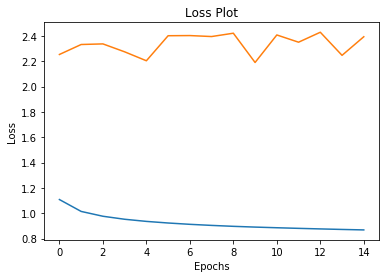

In [81]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [82]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    return final_caption



In [83]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((299, 299), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [84]:
from nltk.translate.bleu_score import sentence_bleu

In [85]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

4186 [  3   2  12  11 199   5   2  91  37   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]


C:\Users\e0368301\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\e0368301\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\e0368301\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

BELU score: 1.384292958842266e-229
Real Caption: a man with sunglasses in a pink shirt
Prediction Caption: a red headed man is race on a ball


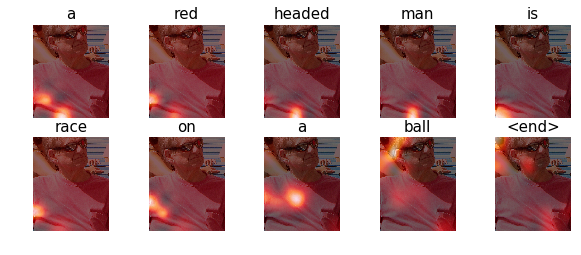

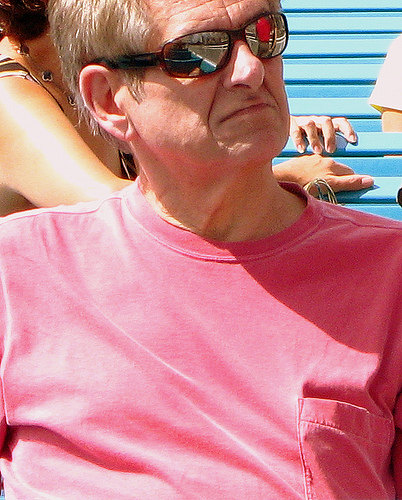

In [88]:

rid = np.random.randint(0, len(img_name_val))
test_image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
print(rid, cap_val[rid])

result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

captions=beam_evaluate(test_image)
print(captions)